In [ ]:
#Зашрузка библиотек:
!pip install vk
import warnings
import vk
import time
import pandas as pd
import seaborn as sns
import numpy as np
import math
from matplotlib import pyplot as plt

from scipy.cluster.hierarchy import dendrogram
from sklearn.decomposition import PCA
from sklearn.manifold import *
from sklearn.cluster import *
from sklearn.metrics import *
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
#Получение токена:

#https://oauth.vk.com/authorize?client_id=damnitonce&display=page&redirect_uri=https://oauth.vk.com/blank.html&scope=friends,photos,audio,video,status,wall,groups,notifications,stories,offline&response_type=token

session1 = vk.Session(access_token='#')
session2 = vk.Session(access_token='#')

api1 = vk.API(session1)    
api2 = vk.API(session2)    
version = 5.131

In [3]:
#1) Парсинг данных друзей:
friends1 = api1.friends.get(v = version)
friends2 = api2.friends.get(v = version)
print('Количество друзей:', friends1['count'] + friends2['count'])

Количество друзей: 427


In [4]:
#2) Присвоение наименований полей:
friends_ids_list1 = friends1['items']
friends_ids_list2 = friends2['items']
fields_name = ['id','sex', 
               'relation', 'universities', 'deactivated',
               'has_photo', 'counters', 
              ]

In [5]:
#3) Парсинг общих данных о пользователях:
dict_users_requests1, dict_users_requests2  = {}, {}
results1, results2 = [], []

for friend in friends_ids_list1:
  dict_results1 = {}
  dict_users_requests1 = {}
  for column in fields_name:
    try:
      dict_results1 = {column: 
                     api1.users.get(user_ids = friend,
                      v = version,
                      fields = fields_name)[0][column]
                      }
    except:
      dict_results1 = {column: np.nan}
    finally:
      dict_users_requests1.update(dict_results1)
    time.sleep(1)
  results1.append(dict_users_requests1)

for friend in friends_ids_list2:
  dict_results2 = {}
  dict_users_requests2 = {}
  for column in fields_name:
    try:
      dict_results2 = {column: 
                     api2.users.get(user_ids = friend,
                      v = version,
                      fields = fields_name)[0][column]
                      }
    except:
      dict_results2 = {column: np.nan}
    finally:
      dict_users_requests2.update(dict_results2)
    time.sleep(1)
  results2.append(dict_users_requests2)

print('Датасет с данными о друзьях 2-ух пользователей:') # Объединяем данные из двух источников с удалением дупликатов по id
base1, base2 = pd.DataFrame(results1), pd.DataFrame(results2)
base = pd.concat([base1, base2]).drop_duplicates(subset='id', keep='first', inplace=False)

base = base[(base['deactivated'] != 'deleted') | 
            (base['deactivated'] != 'banned')].reset_index(drop = True) # Отбор только действующих аккаунтов

counters = base['counters'].apply(pd.Series) #Разбиение словаря с данными об статистике на столбцы
universities = base['universities'].apply(pd.Series) #Разбиение словаря с данными об университете на 
                                                     #столбцы по бакалавру и магистратуре
base = pd.merge(base, universities, left_index=True, right_index=True) 
base = pd.merge(base, counters, left_index=True, right_index=True) 
universities = base['0_x'].apply(pd.Series) #Разбиение словаря с данными об университете на столбцы (бакалавр)
base = pd.merge(base, universities, left_index=True, right_index=True)
universities = base[1].apply(pd.Series) #Разбиение словаря с данными об университете на столбцы (магистратура)
base = pd.merge(base, universities, left_index=True, right_index=True)
base = base[['id_x', 'sex', 'relation', 'has_photo', 'audios', 'followers', 'friends', 
             'photos', 'videos', 'pages', 'name_x', 'name_y']] #Отбор нужных столбцов

base = base.replace(np.nan, 0).apply(pd.to_numeric, errors='ignore', downcast = 'signed') #Перевод числовых столбцов в integer

base['sex'] = base['sex'].replace({1:'Женский', 2: 'Мужской'}) #Замена числовой кодировки на строковые значения
base['relation'] = base['relation'].replace({1:'Не женат/Не замужем', 2: 'Есть друг/Есть подруга',
                                            3: 'Помолвлен/Помолвлена', 4: 'Женат/Замужем',
                                            5: 'Всё сложно', 6: 'В активном поиске', 7: 'Влюблён/Влюблена',
                                            8: 'В гражданском браке', 0: 'Не указано'})
base['has_photo'] = base['has_photo'].replace({1:'Присутствует', 0: 'Не присутствует'})
base['name_x'] = base['name_x'].replace({0: 'Не указано'})
base['name_y'] = base['name_y'].replace({0: 'Не указано'})

columns_names = ['id', 'Пол', 'Семейный статус', 'Аватарка', 'Число аудиозаписей', # Список желаемых наименований столбцов
                'Число подписчиков', 'Число друзей', 'Число фотографий', 'Число видеозаписей', 'Число публичных страниц', 
                 'Университет (бакалавриат)', 'Университет (магистратура)']
base.columns = columns_names

base

Датасет с данными о друзьях 2-ух пользователей:


,id,Пол,Семейный статус,Аватарка,Число аудиозаписей,Число подписчиков,Число друзей,Число фотографий,Число видеозаписей,Число публичных страниц,Университет (бакалавриат),Университет (магистратура)
0,1564243,Женский,Не женат/Не замужем,Присутствует,0,206,710,61,189,80,МГУ,Не указано
1,6379880,Мужской,Не указано,Присутствует,1660,0,157,858,0,149,МГПУ,Не указано
2,7335030,Женский,Женат/Замужем,Присутствует,0,68,130,362,8,88,"ТГУС (бывш. ПТИС, ТГИС, ТГАС)",Не указано
3,11026941,Женский,Не указано,Присутствует,0,212,178,133,21,45,СПбГЭУ (ИНЖЭКОН),НИУ ВШЭ (ГУ-ВШЭ)
4,12029390,Мужской,Не указано,Присутствует,0,117,288,29,49,42,Не указано,Не указано
...,...,...,...,...,...,...,...,...,...,...,...,...
405,521295373,Мужской,Не указано,Присутствует,0,30,89,5,87,194,Не указано,Не указано
406,526992636,Женский,Не указано,Присутствует,0,4,50,1,0,12,ЛГУ им. А. С. Пушкина,Не указано
407,528447304,Женский,Женат/Замужем,Присутствует,0,1,10,5,3,43,Не указано,Не указано
408,532187542,Мужской,Не указано,Присутствует,0,0,41,1,15,0,Финансовый университет при Правительстве РФ (б...,Не указано


In [6]:
#4) Парсинг числа сообществ собранных пользователей с типом "Creative work":
k = -1
for ids in base['id'].to_list():
    k+=1
    try:
        group = pd.DataFrame(api1.groups.get(user_id = ids, extended = 1, v = version, fields = 'activity'))['items']
        group = group.apply(pd.Series)['activity']
        group = pd.DataFrame(pd.DataFrame(group.value_counts())).T
        if 'Creative work' in group.columns:
            creative_count = pd.DataFrame(group['Creative work']).iloc[0,0]
            base.loc[k, 'Доля creative-сообществ'] = round(creative_count/group.sum(axis=1).values[0],5)
        elif 'Творчество' in group.columns:
            creative_count = pd.DataFrame(group['Творчество']).iloc[0,0]
            base.loc[k, 'Доля creative-сообществ'] = round(creative_count/group.sum(axis=1).values[0],5)
        else:
            creative_count = 0
            base.loc[k, 'Доля creative-сообществ'] = round(creative_count/group.sum(axis=1).values[0],5)
    except:
        try:
            group = pd.DataFrame(api2.groups.get(user_id = ids, extended = 1, v = version, fields = 'activity'))['items']
            group = group.apply(pd.Series)['activity']
            group = pd.DataFrame(pd.DataFrame(group.value_counts())).T
            if 'Creative work' in group.columns:
                creative_count = pd.DataFrame(group['Creative work']).iloc[0,0]
                base.loc[k, 'Доля creative-сообществ'] = round(creative_count/group.sum(axis=1).values[0],5)
            elif 'Творчество' in group.columns:
                creative_count = pd.DataFrame(group['Творчество']).iloc[0,0]
                base.loc[k, 'Доля creative-сообществ'] = round(creative_count/group.sum(axis=1).values[0],5)
            else:
                creative_count = 0
                base.loc[k, 'Доля creative-сообществ'] = round(creative_count/group.sum(axis=1).values[0],5)
        except:
            base.loc[k, 'Доля creative-сообществ'] = 0
base['Доля creative-сообществ'] = base['Доля creative-сообществ'].astype('float64')
base = base.drop(['id'], axis = 1)
base

,Пол,Семейный статус,Аватарка,Число аудиозаписей,Число подписчиков,Число друзей,Число фотографий,Число видеозаписей,Число публичных страниц,Университет (бакалавриат),Университет (магистратура),Доля creative-сообществ
0,Женский,Не женат/Не замужем,Присутствует,0,206,710,61,189,80,МГУ,Не указано,0.02500
1,Мужской,Не указано,Присутствует,1660,0,157,858,0,149,МГПУ,Не указано,0.04575
2,Женский,Женат/Замужем,Присутствует,0,68,130,362,8,88,"ТГУС (бывш. ПТИС, ТГИС, ТГАС)",Не указано,0.01974
3,Женский,Не указано,Присутствует,0,212,178,133,21,45,СПбГЭУ (ИНЖЭКОН),НИУ ВШЭ (ГУ-ВШЭ),0.08889
4,Мужской,Не указано,Присутствует,0,117,288,29,49,42,Не указано,Не указано,0.13636
...,...,...,...,...,...,...,...,...,...,...,...,...
405,Мужской,Не указано,Присутствует,0,30,89,5,87,194,Не указано,Не указано,0.05288
406,Женский,Не указано,Присутствует,0,4,50,1,0,12,ЛГУ им. А. С. Пушкина,Не указано,0.09524
407,Женский,Женат/Замужем,Присутствует,0,1,10,5,3,43,Не указано,Не указано,0.00000
408,Мужской,Не указано,Присутствует,0,0,41,1,15,0,Финансовый университет при Правительстве РФ (б...,Не указано,0.00000


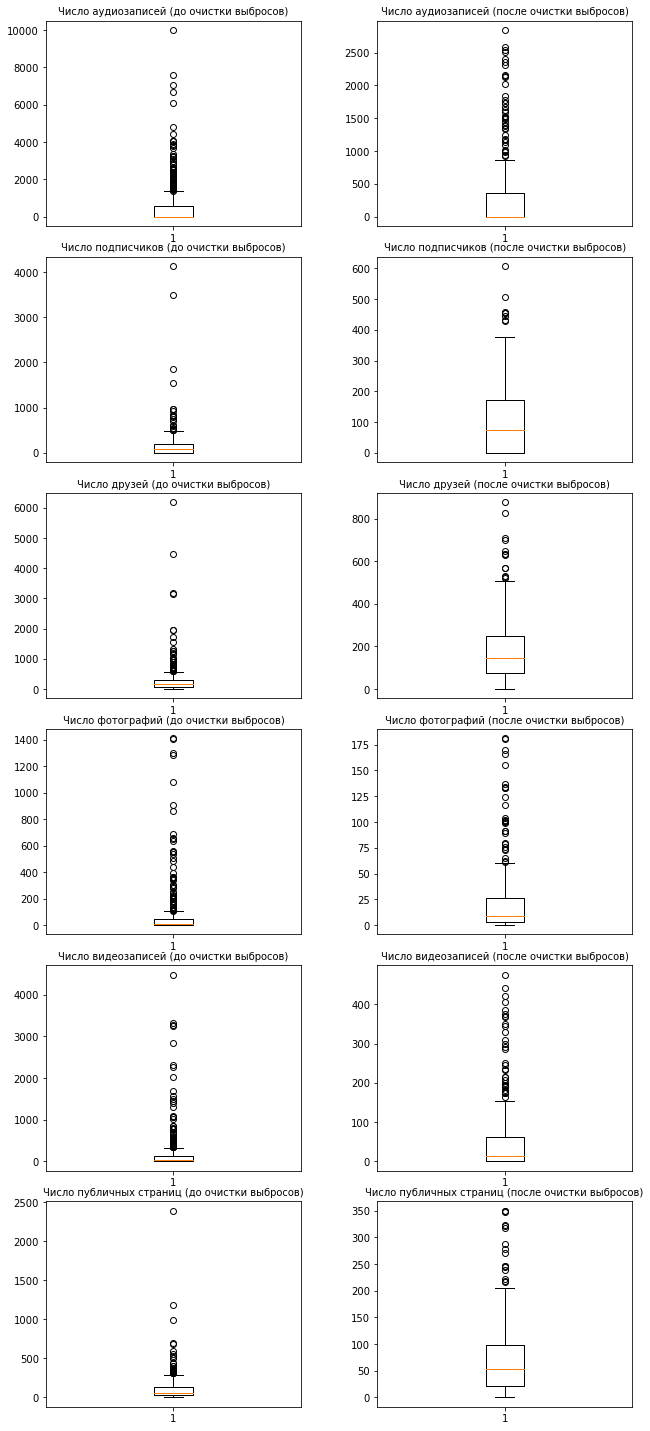

Строк в очищенном датасете: 310


In [7]:
#5) Оценка выбросов по количественным показателям:
numcolumns = ['Число аудиозаписей', 'Число подписчиков', 'Число друзей', 'Число фотографий',
              'Число видеозаписей', 'Число публичных страниц']

fig, ax = plt.subplots(6, 2)
fig.set_size_inches(10.5, 25.5, forward=True)
 
k = -1
for col in numcolumns:
    k+=1
    ax[k, 0].boxplot(base[col])
    ax[k, 0].set_title(col+' (до очистки выбросов)', fontsize=10)

for col in numcolumns: #избавляемся от выбросов
    Q1, Q3 = base[col].quantile(0.15), base[col].quantile(0.85)
    IQR = Q3- Q1
    lower_bound, upper_bound = Q1 - (1.5 * IQR), Q3 + (1.5 * IQR) 
    base = base[(base[col] > lower_bound) & (base[col] < upper_bound)]
  

k = -1
for col in numcolumns:
    k+=1
    ax[k, 1].boxplot(base[col])
    ax[k, 1].set_title(col+' (после очистки выбросов)', fontsize=10)
plt.subplots_adjust(wspace=0.3, hspace=0.15)
plt.show()
print('Строк в очищенном датасете:', base.shape[0])

In [8]:
#5) Оценка выбросов по количественным показателям:
print('Общее число пользователей с указанными университетами (бакалавриат):', 
      base[base['Университет (бакалавриат)'] == 'Не указано'].shape[0])
print('Общее число уникальных университетов у пользователей (бакалавриат):', 
      base['Университет (бакалавриат)'].nunique() - 1, '\n')

print('Число по уникальным указанным университетам пользователей (магистратура):',
      '\n', base['Университет (магистратура)'].value_counts(), '\n')
      
print('Число пользователей по уникальных указанных семейных статусов:', '\n', base['Семейный статус'].value_counts())

base = base.drop(['Семейный статус', 'Университет (магистратура)'], axis = 1) #удаляем слишком слишком пустые столбцы

Общее число пользователей с указанными университетами (бакалавриат): 180
Общее число уникальных университетов у пользователей (бакалавриат): 54 

Число по уникальным указанным университетам пользователей (магистратура): 
 Не указано                                                                     294
НИУ ВШЭ (ГУ-ВШЭ)                                                                 7
ESB Business School Reutlingen                                                   2
Финансовый университет при Правительстве РФ (бывш. ФА при Правительстве РФ)      2
Университет ИТМО                                                                 1
МПГУ (бывш. МГПИ им. Ленина)                                                     1
Сколтех                                                                          1
МФТИ (Физтех)                                                                    1
ГИТР                                                                             1
Name: Университет (магистратура

In [9]:
#6) Кодирование пола, университетов и пристутствия аватарки:
pred = base.copy()
base['Университет (бакалавриат)'] = base['Университет (бакалавриат)'].replace('Не указано', 0)
base.loc[base['Университет (бакалавриат)'] != 0, 
                 'Университет (бакалавриат)'] = 1 #Задание флага наличия высшего образования
base.rename(columns = {'Университет (бакалавриат)' : 'Наличие высшего образования'}, inplace = True)
base['Наличие высшего образования'] = base['Наличие высшего образования'].astype('int')

dicti = {'Присутствует': 1, 'Не присутствует': 0}
base['Аватарка'] = base['Аватарка'].replace(dicti)

dicti = {'Мужской': 1, 'Женский': 0}
base['Пол'] = base['Пол'].replace(dicti)

In [10]:
#7) Нормализация количественных столбцов:
fin = base.copy()
scaler = MinMaxScaler()
fin[numcolumns] = scaler.fit_transform(fin[numcolumns])
print('Финальный датасет:', '\n')
fin

Финальный датасет: 



,Пол,Аватарка,Число аудиозаписей,Число подписчиков,Число друзей,Число фотографий,Число видеозаписей,Число публичных страниц,Наличие высшего образования,Доля creative-сообществ
0,0,1,0.0,0.339374,0.809578,0.337017,0.397059,0.228571,1,0.02500
3,0,1,0.0,0.349259,0.202965,0.734807,0.044118,0.128571,1,0.08889
4,1,1,0.0,0.192751,0.328392,0.160221,0.102941,0.120000,0,0.13636
5,0,1,0.0,0.179572,0.079818,0.044199,0.086134,0.054286,0,0.08696
6,0,1,0.0,0.349259,0.204105,0.016575,0.000000,0.065714,0,0.00000
...,...,...,...,...,...,...,...,...,...,...
405,1,1,0.0,0.049423,0.101482,0.027624,0.182773,0.554286,0,0.05288
406,0,1,0.0,0.006590,0.057013,0.005525,0.000000,0.034286,1,0.09524
407,0,1,0.0,0.001647,0.011403,0.027624,0.006303,0.122857,0,0.00000
408,1,1,0.0,0.000000,0.046750,0.005525,0.031513,0.000000,1,0.00000


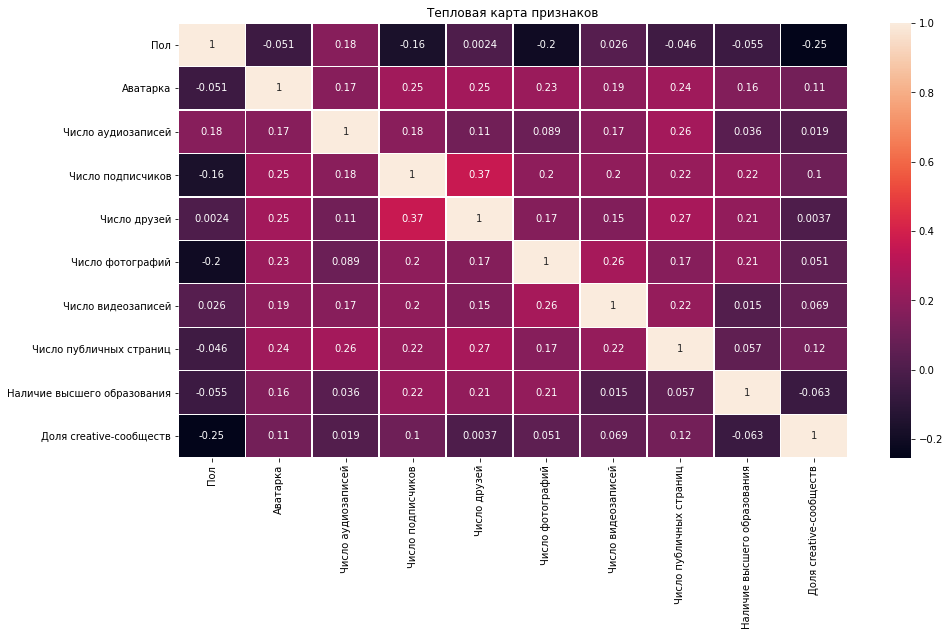

In [11]:
#8) Тепловая карта признаков:
sns.heatmap(fin.corr(), annot=True, linewidths=0.3)
fig = plt.gcf()
fig.set_size_inches(15,8)
fig = plt.title('Тепловая карта признаков')

In [12]:
#9) Присвоение критерия отбора:
fin = fin[fin['Доля creative-сообществ'] >= 0.03] 

In [13]:
#10) Перебор методов кластеризации:
methods = [KMeans(), MiniBatchKMeans(), 
           AffinityPropagation(), 
           AgglomerativeClustering(), 
           MeanShift()]

metrics = pd.DataFrame(columns=['Method', 'Silhouette Score', 'Davies Bouldin Score', 'Inertia'])

r = 7

two_methods = ['KMeans', 'MiniBatchKMeans']

for l in methods:
    est = l.fit(fin)

    method_name = str(est)[:str(est).find('(')]

    to_df = pd.DataFrame(est.labels_)
    to_df.columns = ['labels']
    n_labels = len(to_df.labels.unique())

    if method_name in two_methods:
      if n_labels > 1:
        metrics = metrics.append({'Method': str(est)[:str(est).find('(')], 
                                'Silhouette Score': round(silhouette_score(fin, est.labels_), r),
                                'Davies Bouldin Score': round(davies_bouldin_score(fin, est.labels_), r),
                                'Inertia': round(est.inertia_, r)
                                }, ignore_index=True)
      else:
        metrics = metrics.append({'Method': str(est)[:str(est).find('(')], 
                                'Silhouette Score': '-',
                                'Davies Bouldin Score': '-',
                                'Inertia': round(est.inertia_, r)
                                }, ignore_index=True)
    else:
      if n_labels > 1:
        metrics = metrics.append({'Method': str(est)[:str(est).find('(')], 
                                'Silhouette Score': round(silhouette_score(fin, est.labels_), r),
                                'Davies Bouldin Score': round(davies_bouldin_score(fin, est.labels_), r),
                                'Inertia': '-'
                                }, ignore_index=True)
      else:
        metrics = metrics.append({'Method': str(est)[:str(est).find('(')], 
                                'Silhouette Score': '-',
                                'Davies Bouldin Score': '-',
                                'Inertia': '-'
                                }, ignore_index=True)

In [15]:
print('Перебор методов кластеризации:')
metrics[(metrics['Silhouette Score'] != '-') & 
        (metrics['Davies Bouldin Score'] != '-')].sort_values(by='Silhouette Score', ascending=False).reset_index(drop = True)

Перебор методов кластеризации:


,Method,Silhouette Score,Davies Bouldin Score,Inertia
0,KMeans,0.419577,1.086904,19.891043
1,MiniBatchKMeans,0.372631,1.249423,20.619459
2,AffinityPropagation,0.359632,1.167959,-
3,AgglomerativeClustering,0.316381,1.400646,-


Оптимальное число клатеров: 4, несмотря на показатели, но исходя из PCA позже


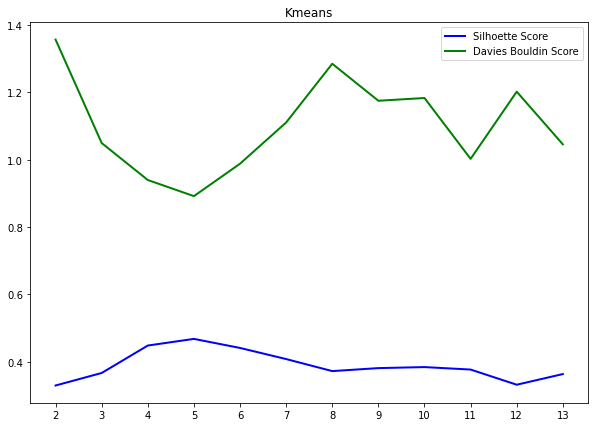

In [16]:
#11) Поиск оптимального числа кластеров:
print('Оптимальное число клатеров: 4, несмотря на показатели, но исходя из PCA позже')
ss_agg = []
bd_agg = []
points = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9 , 10, 11]
labels = ['2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13']
for k in range(2, 14):
  est = KMeans(n_clusters=k)
  est.fit(fin)
  ss_agg.append(silhouette_score(fin, est.labels_))
  bd_agg.append(davies_bouldin_score(fin, est.labels_))
    
plt.figure(figsize=(10, 7))
plt.plot(ss_agg, linewidth=2, color='blue')
plt.plot(bd_agg, linewidth=2, color='green')
plt.title('Kmeans')
plt.legend(['Silhoette Score', 'Davies Bouldin Score'], loc=1)


plt.xticks(points, labels)
plt.show()

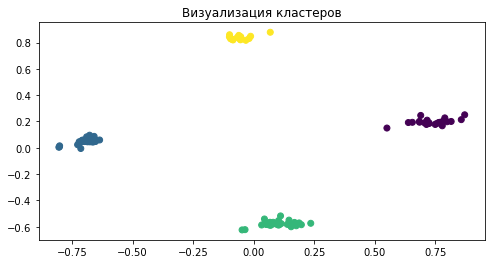

In [17]:
#12) Визуализация кластеров:
k_opt = 4
model = KMeans(n_clusters=k_opt)
model.fit(fin)

pca = PCA(n_components = 2).fit_transform(fin)

plt.figure(figsize=(8, 4))
plt.scatter(pca[:, 0], pca[:, 1], c = model.labels_)
plt.title('Визуализация кластеров')
plt.show()

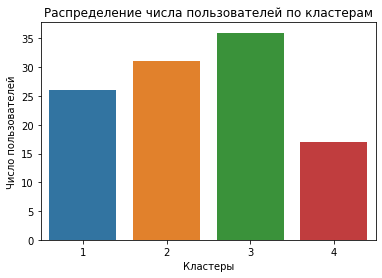

In [18]:
#13) Распределение числа пользователей по кластерам:
labels = pd.DataFrame(model.labels_)
labels.columns = ['cluster']
fin_clusters = pd.concat([fin, labels], axis=1)

graph = sns.countplot(fin_clusters.cluster)
graph.set_xticklabels(np.arange(1,k_opt+1))
plt.xlabel('Кластеры')
plt.ylabel('Число пользователей')
plt.title('Распределение числа пользователей по кластерам')
plt.show()

Визуализация усреднённых признаков кластеров


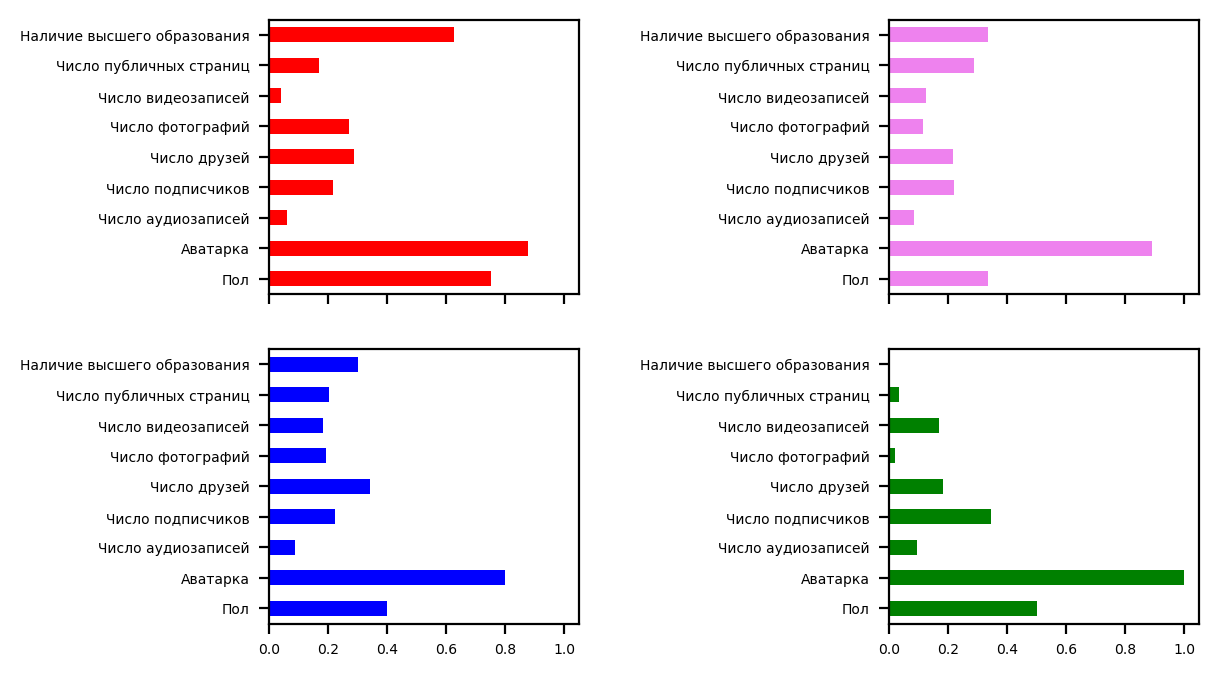

In [19]:
#15) Визуализация усреднённых признаков кластеров:
print('Визуализация усреднённых признаков кластеров')
fin_clusters = fin_clusters.drop('Доля creative-сообществ', axis = 1)

fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True)
plt.subplots_adjust(wspace=1)
k = -1
c = ['red', 'violet', 'blue', 'green', 'black', 'brown']
for i in range(2):
    for j in range(2):
        fig.set_dpi(200)
        ax = axs[i,j]
        k += 1
        fin_clusters[fin_clusters['cluster'] == k].groupby('cluster').mean().T.plot.barh(ax = ax, color = c[k], legend = False)
        ax.tick_params(labelsize = 5)

In [1]:
#17) Описание кластеров:
print('1-ый кластер "мужчины-фотографы" (красный): большинство мужчин с аватарками, половина из которых обладают высшим образованием', 
      'с большим  числом друзей и фотографий по сравнению с другими кластерами, но с практически отсутствующими видеозаписями и         аудизаписями.', '\n')
print('2-ой кластер "обычные девушки" (розовый): большинство девушек с аватарками, 1/3 из которых уже получила высшее образование,    обладает наибольшим числом подписок на публичные страницы и со средними значениями по всем исследуемым параметрам.', '\n')
print('3-ий кластер "социальные" (синий): равногендерная группа с автарками, в которой только 1/3 успела получить высшее образование и имеет самое большое число друзей по сравнению с другимит кластерами со средними показателями заполненности страницы            медиаматериалами.', '\n')
print('4-ый кластер "дети" (зелёный): равногендерная группа, у всех из которой есть аватарки, но нет высшего образования. Помимо      этого, есть большое число подписчиков и видеозаписей, при практически отсутствующих фотографиях и маленьком числе подписок.')

1-ый кластер "мужчины-фотографы" (красный): большинство мужчин с аватарками, половина из которых обладают высшим образованием с большим  числом друзей и фотографий по сравнению с другими кластерами, но с практически отсутствующими видеозаписями и         аудизаписями. 

2-ой кластер "обычные девушки" (розовый): большинство девушек с аватарками, 1/3 из которых уже получила высшее образование,    обладает наибольшим числом подписок на публичные страницы и со средними значениями по всем исследуемым параметрам. 

3-ий кластер "социальные" (синий): равногендерная группа с автарками, в которой только 1/3 успела получить высшее образование и имеет самое большое число друзей по сравнению с другимит кластерами со средними показателями заполненности страницы            медиаматериалами. 

4-ый кластер "дети" (зелёный): равногендерная группа, у всех из которой есть аватарки, но нет высшего образования. Помимо      этого, есть большое число подписчиков и видеозаписей, при практически отсутствующих

In [20]:
#17) Система предсказания:
pred = pred.drop('Доля creative-сообществ', axis = 1)

marks = {}
for column in (pred.columns): 
    colname = column 
    if column == 'Университет (бакалавриат)':
        column = 'Университет (бакалавриат) - если нет, то "Отсутствует"'
    elif column == 'Аватарка':
        column = 'Аватарка - "Присутствует/Не присутствует"'
    coloname = column+": "
    ans = input(coloname) 
    marks[colname] = ans

pred = pred.append(pd.DataFrame(marks, index = [0]))
dicti = {'Присутствует': 1, 'Не присутствует': 0}
pred['Аватарка'] = pred['Аватарка'].replace(dicti)
dicti = {'Мужской': 1, 'Женский': 0}
pred['Пол'] = pred['Пол'].replace(dicti)
dicti = {'Отсутствует': 0, 'Не указано': 0}
pred['Университет (бакалавриат)'] = pred['Университет (бакалавриат)'].replace(dicti)
pred.loc[pred['Университет (бакалавриат)'] != 0, 
                 'Университет (бакалавриат)'] = 1
pred.rename(columns = {'Университет (бакалавриат)' : 'Наличие высшего образования'}, inplace = True)
pred['Наличие высшего образования'] = pred['Наличие высшего образования'].astype('int')
pred[numcolumns] = scaler.fit_transform(pred[numcolumns])

model = KMeans(n_clusters=k_opt)
model.fit(pred)

pred = pred.reset_index()    
labels = pd.DataFrame(model.labels_)
labels.columns = ['cluster']
pred_clusters = pd.concat([pred, labels], axis=1)
print('Номер кластера пользователя:', pred_clusters.iloc[-1,-1]+1)

Пол: Мужской
Аватарка - "Присутствует/Не присутствует": Присутствует
Число аудиозаписей: 56
Число подписчиков: 78
Число друзей: 87
Число фотографий: 54
Число видеозаписей: 32
Число публичных страниц: 65
Университет (бакалавриат) - если нет, то "Отсутствует": МГУ
Номер кластера пользователя: 1
